# Batch Job Analysis-by Transaction Counts and Interarrival Per Useid

In [93]:
import pandas as pd
import numpy as np
from scipy import stats 
import datetime
import matplotlib.pyplot as plt
import scipy 
import cv2


def readlog(filename="d:\IAG\ORM\uapwas10-orm-monitor.log",starttime=datetime.time(9,0,0),endtime=datetime.time(18,0,0)):
    columnlist=['StartTime','EndTime','Session ID','Session CreateTime','TransactionType','UserID']
    df = pd.read_csv(filename,names=columnlist,header=None)
    df.drop(df.columns[[2,3]],axis=1,inplace=True) # Seesion id and createtype dropped
    
    #columnlist=['StartTime','EndTime','TransactionType','UserID']
    #df.columns=columnlist

    for c in df.columns:
        df[c]=df[c].str.extract('=(.*)', expand=False).ffill()

    df['StartTime']=pd.to_datetime(df['StartTime'])    
    df['EndTime']=pd.to_datetime(df['EndTime'])
    #df['ResponseTime']=df['EndTime']-df['StartTime']
    
    #TobeRemoved=np.arange(1,3).tolist()
    df.drop(df.columns[[1]], axis=1, inplace=True)
    #from IPython.core.debugger import Tracer; Tracer()() 
    df.sort(['UserID', 'StartTime'], inplace=True)
    df['Interarrival'] = df.groupby('UserID')['StartTime'].diff()
    df.set_index(['StartTime'],inplace=True)  
    df=df.between_time('9:00', '12:00')
    #df.sort_index(inplace=True)
    #df=df.set_index(['UserID'],append=True)      
    return df

def readlog1(filename="d:\IAG\ORM\uapwas10-orm-monitor.log",starttime=datetime.time(9,0,0),endtime=datetime.time(18,0,0)):
    columnlist=['StartTime','EndTime','Session ID','Session CreateTime','TransactionType','UserID']
    df = pd.read_csv(filename,names=columnlist,header=None)
    df.drop(df.columns[[2,3]],axis=1,inplace=True) # Seesion id and createtype dropped
    
    #columnlist=['StartTime','EndTime','TransactionType','UserID']
    #df.columns=columnlist

    for c in df.columns:
        df[c]=df[c].str.extract('=(.*)', expand=False).ffill()

    df['StartTime']=pd.to_datetime(df['StartTime'])    
    df['EndTime']=pd.to_datetime(df['EndTime'])
    df['ResponseTime']=df['EndTime']-df['StartTime']   
    df.sort(['StartTime'], inplace=True)    
    df.set_index(['StartTime'],inplace=True)
    
    df=df.between_time(starttime, endtime)   
    #df=df.between_time('12:00', '15:00') 
    return df

def avginterval(df):
    #a=(df.groupby(pd.TimeGrouper('1Min'))['ResponseTime'].sum()/df.groupby(pd.TimeGrouper('1Min'))['ResponseTime'].count())/datetime.timedelta(milliseconds=1)
    a=df['ResponseTime']/datetime.timedelta(milliseconds=1)  
    a=a.resample('1min').mean()
    return a.dropna()

def floatna(df):
    a=df['ResponseTime']/datetime.timedelta(seconds=1)
    return a.dropna()




The following function it to find the top transactions with suspicion

In [ ]:
import datetime
def toptrans(filename,timethreshold=2000):
    start= datetime.time(9,0,0)
    end = datetime.time(12,0,0)
    df=readlog(filename,start,end)
    datetimes=pd.Series(df.index[0]).dt.dayofweek
    from IPython.core.debugger import Tracer; Tracer()() 
    if datetimes[0] in range(0, 5):  #0-4,Monday to Friday
    #df['ResponseTime']=df['ResponseTime']/datetime.timedelta(milliseconds=1)
        df['Interarrival']=df['Interarrival']/datetime.timedelta(milliseconds=1)    
        a=df.groupby('UserID')['TransactionType'].count()
        b=df.groupby('UserID').apply(lambda x: x[x['Interarrival'] <timethreshold]['Interarrival'].count()) #.nlargest(2)
        d=pd.concat([a,b],axis=1)
        d.columns.values[0]="Numnber of Transactions"
        d.columns.values[1]="No. of ShortInterArrival Transactions"
        idx1=d['Numnber of Transactions'].nlargest(2).index
        idx2=d["No. of ShortInterArrival Transactions"].nlargest(2).index
        idx=idx1.union(idx2)
        output=d[(d.index.isin(idx))]
        output['DateTimes']=df.index.values[0]
        return output
    else:
        return None
     

import glob
path = "d:\IAG\ORM\monitor.log.201*"
for fname in glob.glob(path):    
    c=toptrans(fname)
    if c is not None:
        c.to_csv("d:\IAG\ORM\orm.csv",mode='a',header=False)
    #c.to_csv("d:\IAG\ORM\orm.csv",header=False)

D:\Program Files\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:28: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


> <ipython-input-2-411596b488df>(8)toptrans()
      6     datetimes=pd.Series(df.index[0]).dt.dayofweek
      7     from IPython.core.debugger import Tracer; Tracer()()
----> 8     if datetimes[0] in range(0, 5):  #0-4,Monday to Friday
      9     #df['ResponseTime']=df['ResponseTime']/datetime.timedelta(milliseconds=1)
     10         df['Interarrival']=df['Interarrival']/datetime.timedelta(milliseconds=1)

ipdb> datetimes
0    6
dtype: int64
ipdb> pd.Series(df.index[0]).dt
ipdb> df.index[0]
Timestamp('2017-01-29 09:22:01.745000')
ipdb> df.index[0].date
<built-in method date of Timestamp object at 0x000000000A3106D8>
ipdb> a=df.index[0].date
filename = d:\IAG\ORM\monitor.log.2017-01-29
timethreshold = 2000
ipdb> a
filename = d:\IAG\ORM\monitor.log.2017-01-29
timethreshold = 2000
ipdb> pd.Series(df.index[0]).dt.date
0    2017-01-29
dtype: object
ipdb> datetimes[0]
6


Student T test

D:\Program Files\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:42: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Cophenetic Correlation Coefficient=0.74193


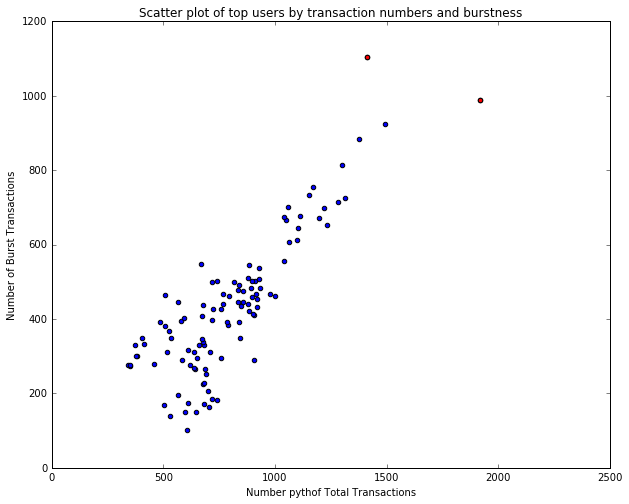

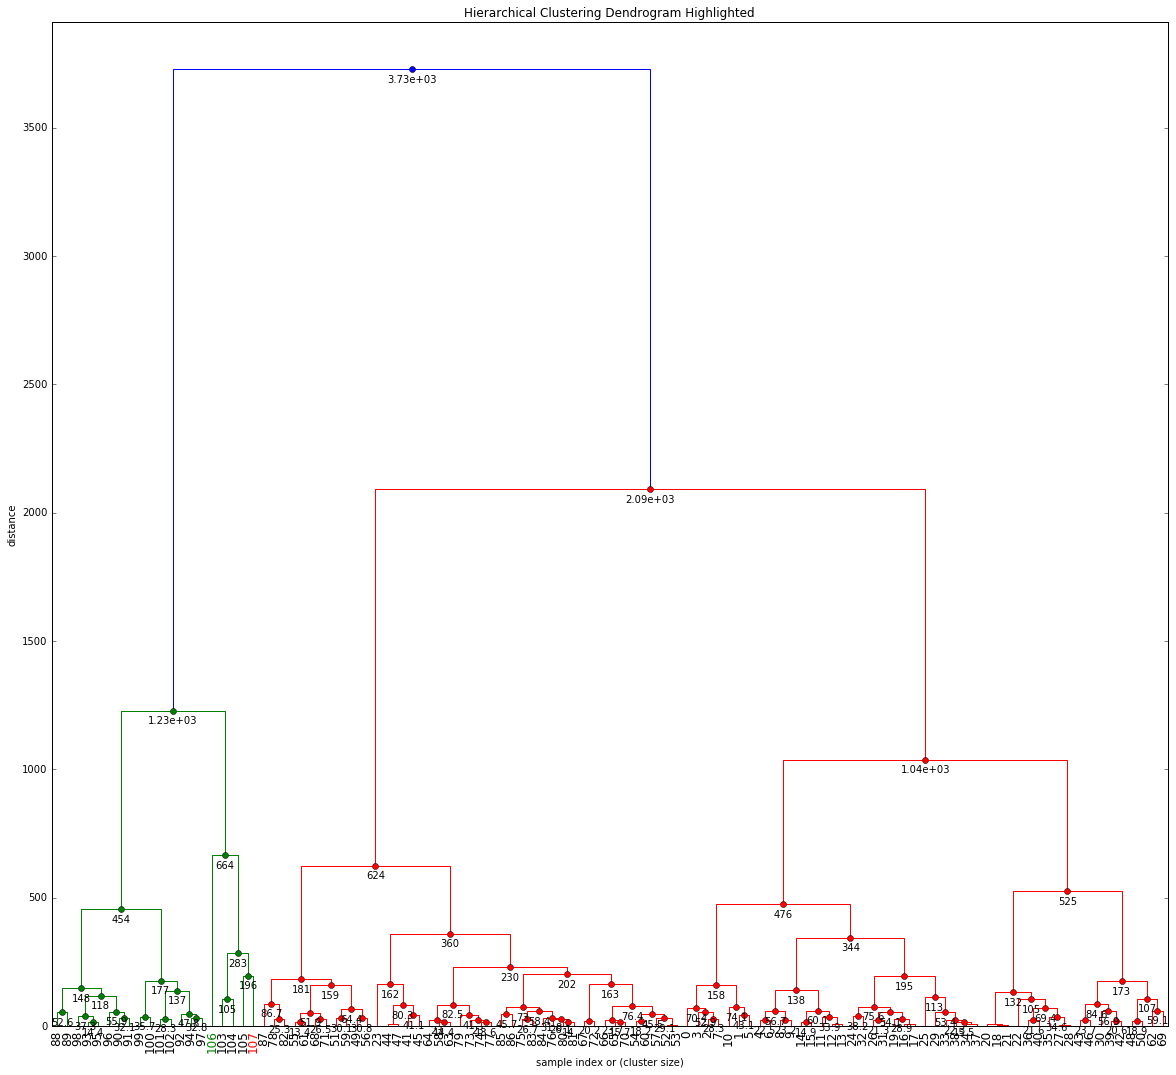

,UserID,DateTime,TotalTransactions,ShortInterArrivalTransactions
88,554572,2017-02-02 09:10:35.881,1042,557
89,558378,2017-01-31 10:44:10.911,1061,606
90,550123,2017-02-21 09:59:18.192,1101,613
91,558378,2017-03-09 09:38:28.363,1104,645
92,554572,2017-03-16 10:10:21.638,1233,652
93,558378,2017-02-22 09:41:10.929,1051,667
94,554572,2017-02-28 10:32:19.103,1198,672
95,extanh103,2017-02-22 09:41:10.929,1039,675
96,558378,2017-03-10 09:57:34.325,1114,676
97,554572,2017-03-20 10:06:58.636,1218,698


In [23]:
# needed imports
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from IPython.display import display


#some setting for this notebook to actually show the graphs inline, you probably won't need this
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
def fancy_dendrogram(*args, **kwargs):
    plt.figure(figsize=(20, 18))
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram Highlighted')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

def datapre(filename="d:\IAG\ORM\orm.csv"):
    columnlist=['UserID','TotalTransactions','ShortInterArrivalTransactions','DateTime']
    df=pd.read_csv(filename,index_col=[0,3],names=columnlist,header=None)
    df=df[~df.index.duplicated()]   # drop duplicate indices
    df=df.sort(['ShortInterArrivalTransactions'],ascending=1)
    return df

def hiercluster(df1,cutdistance=0.2):
    d=cutdistance*sch.distance.pdist(df1).max()
    Z = linkage(df1, 'ward')
    #print(d)
    ind = sch.fcluster(Z, d, 'distance')
    
    c, coph_dists = cophenet(Z, pdist(df1))
    print("Cophenetic Correlation Coefficient=%1.5f" % (c))
    df1.reset_index(inplace=True)   
    totaltransidx=df1['TotalTransactions'].idxmax()
    bursttransidx=df1["ShortInterArrivalTransactions"].idxmax()
    idxs=[totaltransidx,bursttransidx]
    clusterid=ind[totaltransidx]
    B = np.where(ind==clusterid)[0]
    
    
    #plot scatter
    plt.figure(figsize=(10, 8))
    plt.scatter(df['TotalTransactions'], df["ShortInterArrivalTransactions"])
    plt.title('Scatter plot of top users by transaction numbers and burstness')
    plt.xlabel('Number pythof Total Transactions')
    plt.ylabel('Number of Burst Transactions')
    #plt.scatter(df[:,0], df[:,1])  # plot all points
    plt.scatter(df1.iloc[idxs]['TotalTransactions'], df.iloc[idxs]["ShortInterArrivalTransactions"], c='r')  # plot interesting points in red again
    plt.show()
    
    # calculate full dendrogram
    
    dn=fancy_dendrogram(
    Z,
    #truncate_mode='lastp',
    #p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
    label_colors={totaltransidx:"g",bursttransidx:"r"}
    ax = plt.gca()
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:        
        if int(lbl.get_text()) in label_colors:
            lbl.set_color(label_colors[int(lbl.get_text())])
    plt.show()    
    return Z

def anomaly(dataf,distance):    
    Z = linkage(dataf, 'ward')
    ind = sch.fcluster(Z, distance, 'distance')
    dataf.reset_index(inplace=True)   
    totaltransidx=dataf['TotalTransactions'].idxmax()
    bursttransidx=dataf["ShortInterArrivalTransactions"].idxmax()
    idxs=[totaltransidx,bursttransidx]
    clusterid=ind[totaltransidx]
    B = np.where(ind==clusterid)[0]
    return dataf.ix[B]

df=datapre()
z1=hiercluster(df)
df=datapre()
output=anomaly(df,1240)
display(output)
    

The following cell is to calculate the index of dispersion for service process

In [94]:
#from datetime import timedelta
import datetime
import numpy
def IDC(filename,start= datetime.time(12,0,0),end = datetime.time(13,0,0)):
    Busy=[]
    Completed=[]    
    resolution=60   
    
    df=readlog1(filename,start,end)
    
    if len(df.index)==0:
        return -1
    #from IPython.core.debugger import Tracer; Tracer()() 
    #print(df.iloc[0])
    dt1=pd.Series(df.index[0]).dt.date     
    startparts=datetime.datetime.combine(dt1[0], start) 
    stoparts=startparts + timedelta(seconds=resolution) # every 60s interval
    endparts=datetime.datetime.combine(dt1[0], end)
    
    Bindex=-1
    i=0
    while stoparts<=endparts : # calculate busy time in Bk, check transaction one by one   
        
        #startpoint=pd.Series(df.index[i]).dt.time[0]
        startpoint=df.index[i]        
        endpoint=df.iloc[i]['EndTime'].to_datetime() #convert pandas timestamp to date time
        Busy.append(df.iloc[i]['ResponseTime'])
        while endpoint<stoparts:
            if i==len(df.index)-1: # end of df               
                break
            i=i+1            
            startpoint=df.index[i]
            if df.iloc[i]['EndTime'].to_datetime()>endpoint: #otherwise absorbed,just ignore
                if startpoint<endpoint: #'overlap'
                    startpoint=endpoint
                endpoint=df.iloc[i]['EndTime'].to_datetime()   #New endpoint
                Busy[Bindex]=Busy[Bindex]+endpoint-startpoint   
        Bindex=Bindex+1
        if Bindex>0:   
            Completed.append(i)   # number of completed in this section            
        else:     #first
            Completed.append(i) # number of transactions
        stoparts=stoparts + timedelta(seconds=60)  # next cycle
    for i in reversed(xrange(1,len(Completed))):   
        Completed[i]=Completed[i]-Completed[i-1]
    
    tol=0.2 # tolerance
    t=timedelta(seconds=resolution)
    Yt=0.0
    Yt_T=0.0
    while t<((endparts-startparts)/10):
        Nt=[]
        Nindex=0
        Nt.append(0)
        i=0  #i is the Busy index now    
        sumBusy=timedelta(seconds=0)   
        while i<len(Busy):   
            sumBusy=sumBusy+Busy[i]
            Nt[Nindex]=Completed[i]+Nt[Nindex]
            if sumBusy>t: #overflow Nt forms, reinitialize
                
                if Nt[Nindex]<100: #too few element
                    if Yt_T>0:
                        return Yt_T
                    else:
                        return -1
                Nindex=Nindex+1
                Nt.append(0)
                sumBusy=timedelta(seconds=0)   
            i=i+1 
        Yt_T=Yt
        Yt=np.var(Nt)/np.mean(Nt)
        #print(Yt,Yt_T)
        if  Yt_T>0 and abs(1-Yt/Yt_T)<=tol:
            return Yt
        
        #from IPython.core.debugger import Tracer; Tracer()() 
        t=t+timedelta(seconds=resolution)         
    return Yt

for i in xrange(8,10):
    st=dt.time(i)
    end=dt.time(i+1)    
    a=IDC("d:\IAG\ORM\uapwas10-orm-monitor.log",st,end)
    print(st,end,a)

space


D:\Program Files\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:50: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(datetime.time(8, 0), datetime.time(9, 0), 14.294918851435705)
space
(datetime.time(9, 0), datetime.time(10, 0), 24.268162324679885)


In [80]:
import datetime as dt


24
